# K‑Means Clustering of Commodities by Price Trends

**Goal:** cluster commodities based on their price time-series trends:

- Loads the dataset.
- Preprocesses and pivots price time series.
- Extracts trend features and scales them.
- Determines the best number of clusters using the Elbow method and Silhouette score.
- Runs K‑Means, visualizes clusters, and saves results.


In [48]:
# Imports Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

plt.rcParams['figure.figsize'] = (10,5)


In [49]:
# Load data: tries to use an existing `df` variable.
try:
    df
    print('Using existing variable `df` from the environment.')
except NameError:
    data_path = Path('data1.xlsx')
    if data_path.exists():
        print('Loading data from data1.xlsx')
        df = pd.read_excel(data_path)
    else:
        raise FileNotFoundError('data1.xlsx not found in notebook folder.')

print('Data loaded. Shape:', df.shape)
display(df.head(10))

Using existing variable `df` from the environment.
Data loaded. Shape: (2488, 8)


,Commodity Name,Date,Units of Measure,Average Price Previous Year,Average Price Previous Month,Current Average price,% monthly change,% yearly change
0,Sugar,2012-11-01 00:00:00,1 Kg,173.4,119,119.73,0.6,-30.9
1,Wheat Flour,2012-11-01 00:00:00,2 Kg,149.91,133.62,134.91,1,-10
2,Cooking Fat,2012-11-01 00:00:00,1 KG,241.15,229.05,229.03,0,-5
3,Sifted Maize Flour,2012-11-01 00:00:00,2 Kg,117.33,113.62,114.52,0.8,-2.4
4,Tomatoes,2012-11-01 00:00:00,1 Kg,69.06,58.52,66.85,14.2,-3.2
5,Rice- Grade 2,2012-11-01 00:00:00,1 Kg,102.28,97.8,98.75,1,-3.5
6,Green Grams,2012-11-01 00:00:00,1 Kg,135.56,116.32,119.67,2.9,-11.7
7,Maize Grain -Loose,2012-11-01 00:00:00,1 Kg,43.17,41.86,41.92,0.1,-2.9
8,Cooking Oil,2012-11-01 00:00:00,1 litre,237.16,231.26,230.87,-0.2,-2.7
9,Electricity,2012-11-01 00:00:00,50 Kw/hr,819,657.5,584.5,-11.1,-28.6


In [50]:
# Quick inspection: try to detect columns for commodity, date, price
print('Columns:', list(df.columns))

# Heuristics for column names
col_lower = [c.lower() for c in df.columns]
commodity_col = None
date_col = None
price_col = None
for c in df.columns:
    cl = c.lower()
    if any(x in cl for x in ['commodity', 'product', 'item', 'name']):
        commodity_col = c
        break
for c in df.columns:
    cl = c.lower()
    if 'date' in cl or 'month' in cl or 'year' in cl:
        date_col = c
        break
for c in df.columns:
    cl = c.lower()
    if any(x in cl for x in ['price', 'value', 'amount', 'avg']):
        price_col = c
        break

print('Inferred columns: commodity_col=', commodity_col, ', date_col=', date_col, ', price_col=', price_col)
if commodity_col is None or date_col is None or price_col is None:
    print('\nWarning: automatic detection failed for some columns. You may need to set them manually, e.g.')
    print("commodity_col = 'commodity_name'\ndate_col = 'date'\nprice_col = 'current_average_price'")

Columns: ['Commodity Name', 'Date', 'Units of Measure', 'Average Price Previous Year', 'Average Price Previous Month', 'Current Average price', ' % monthly change', '% yearly change']
Inferred columns: commodity_col= Commodity Name , date_col= Date , price_col= Average Price Previous Year


In [51]:
# If automatic detection is wrong, override these variable names here:
# commodity_col = 'commodity_name'
# date_col = 'date'
# price_col = 'current_average_price'

try:
    commodity_col, date_col, price_col
except NameError:
    pass


In [52]:
#  Clean and pivot data for time-series clustering

# Ensure correct dtypes
df_proc = df[[commodity_col, date_col, price_col]].copy()
df_proc[date_col] = pd.to_datetime(df_proc[date_col], errors='coerce')

# Convert prices to numeric
df_proc[price_col] = pd.to_numeric(df_proc[price_col], errors='coerce')

# Drop missing essentials
df_proc = df_proc.dropna(subset=[commodity_col, date_col, price_col])

# Pivot to wide format (commodities × dates)
ts = df_proc.pivot_table(index=commodity_col, columns=date_col, values=price_col, aggfunc='mean')

# Sort columns by date
ts = ts.reindex(sorted(ts.columns), axis=1)
print('Time-series matrix shape (commodities x timepoints):', ts.shape)

Time-series matrix shape (commodities x timepoints): (239, 143)


In [53]:
# Impute missing values: linear interpolation along time axis, then fill remaining with median
ts_interp = ts.copy()

# Interpolate each commodity's series
ts_interp = ts_interp.apply(lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)

# Fill remaining na with row median
ts_interp = ts_interp.apply(lambda r: r.fillna(r.median()), axis=1)

# If some rows are still all-NaN, drop them
before = ts_interp.shape[0]
ts_interp = ts_interp.dropna(how='all')
after = ts_interp.shape[0]
print(f'Dropped {before-after} commodities that had no price data.')

# Standardize time series per timepoint (columns) so features compare trends rather than level
scaler = StandardScaler()
X_time = scaler.fit_transform(ts_interp.fillna(0).values)  # shape (n_commodities, n_timepoints)

print('Feature matrix ready. Shape:', X_time.shape)

Dropped 0 commodities that had no price data.
Feature matrix ready. Shape: (239, 143)


In [54]:
# compute simple trend features (slope, mean, std, skewness) per commodity
from scipy.stats import linregress

def compute_trend_features(arr, dates=None):
    # arr: 1D price values (may contain NaN)
    y = np.array(arr, dtype=float)
    if dates is None:
        x = np.arange(len(y))
    else:
        # convert dates to numeric ordinal
        x = np.array([pd.Timestamp(d).toordinal() for d in dates])
    # handle missing by masking
    mask = ~np.isnan(y)
    if mask.sum() < 2:
        return dict(mean=np.nan, std=np.nan, slope=np.nan)
    ys = y[mask]
    xs = x[mask]
    slope, intercept, r, p, se = linregress(xs, ys)
    return dict(mean=np.nanmean(y), std=np.nanstd(y), slope=slope)

features = []
dates = ts_interp.columns
for idx, row in ts_interp.iterrows():
    feats = compute_trend_features(row.values, dates=dates)
    features.append(feats)

features_df = pd.DataFrame(features, index=ts_interp.index)
display(features_df.head())

# Combine timeseries (flatten) with trend features if desired. For clustering by trend, we will use the time-series matrix X_time.


,mean,std,slope
Commodity Name,,,
(Shanzu to Nairobi),1800.00,0.000000e+00,0.000000e+00
2 Bedroom House Rent,17333.33,3.637979e-12,6.966605e-29
Actual monthly house\nrent - single room,3628.45,9.094947e-13,1.741651e-29
Aromatic Unbroken Rice\n(Pishori/Basmati e.t.c),466.78,1.136868e-13,-2.177064e-30
Aromatic Unbroken Rice (Pishori/Basmati e.t.c),442.30,1.705303e-13,3.265596e-30


k=2: inertia=14224.93, silhouette=0.8881
k=3: inertia=3710.70, silhouette=0.8858
k=4: inertia=1715.93, silhouette=0.8820
k=5: inertia=944.92, silhouette=0.8309
k=6: inertia=393.42, silhouette=0.8438
k=7: inertia=281.19, silhouette=0.8481
k=8: inertia=217.49, silhouette=0.8430
k=9: inertia=161.90, silhouette=0.8450
k=10: inertia=121.53, silhouette=0.8366


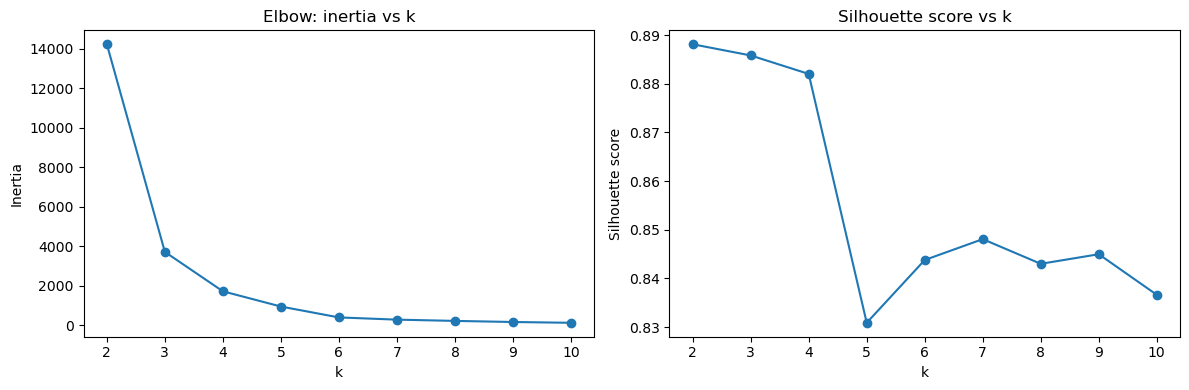

In [55]:
# Determine best K: run KMeans for k=2..10 (or up to n_samples-1)
from sklearn.metrics import pairwise_distances_argmin_min

n_samples = X_time.shape[0]
max_k = min(10, max(2, n_samples-1))
inertias = []
sil_scores = []
K_range = range(2, max_k+1)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_time)
    inertias.append(km.inertia_)
    # silhouette requires at least 2 clusters and < n_samples
    try:
        sil = silhouette_score(X_time, labels)
    except Exception as e:
        sil = np.nan
    sil_scores.append(sil)
    print(f'k={k}: inertia={km.inertia_:.2f}, silhouette={sil:.4f}')

# Plot elbow and silhouette
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, marker='o')
plt.title('Elbow: inertia vs k')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.title('Silhouette score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.tight_layout()

In [56]:
# Choose best k by silhouette (break ties by lower inertia)
best_k = int(K_range[np.nanargmax(sil_scores)])
print('Best k chosen by silhouette score:', best_k)

km_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_final = km_final.fit_predict(X_time)

cluster_assignments = pd.Series(labels_final, index=ts_interp.index, name='cluster')
display(cluster_assignments.value_counts().sort_index())

Best k chosen by silhouette score: 2


cluster
0    226
1     13
Name: count, dtype: int64

Elbow Plot (Left)
- This shows the within-cluster sum of squares (inertia) decreasing as k increases. The inertia drops sharply from k=2 to k=3, then continues to decrease more gradually. The "elbow" - where the rate of decrease slows significantly - appears to be around k=3 or k=4. After k=5, the curve flattens considerably, with diminishing returns from adding more clusters.

Silhouette Score (Right)
- This measures how well-separated and cohesive the clusters are (higher is better, range -1 to 1):

- k=2: Highest score (~0.889) - indicates very well-defined clusters
- k=3-4: Still high (~0.886-0.882) - maintains good cluster quality
- k=5: Sharp drop (~0.831) - suggests this may not be a natural clustering structure
- k=6-10: Fluctuates between 0.836-0.848 - moderate but inconsistent quality

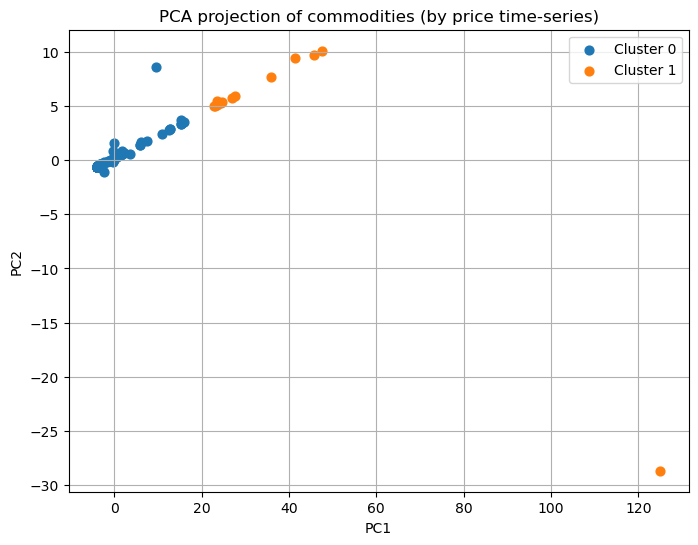

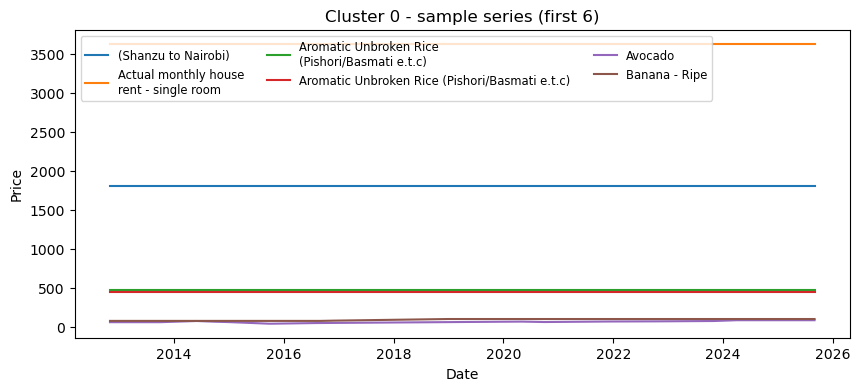

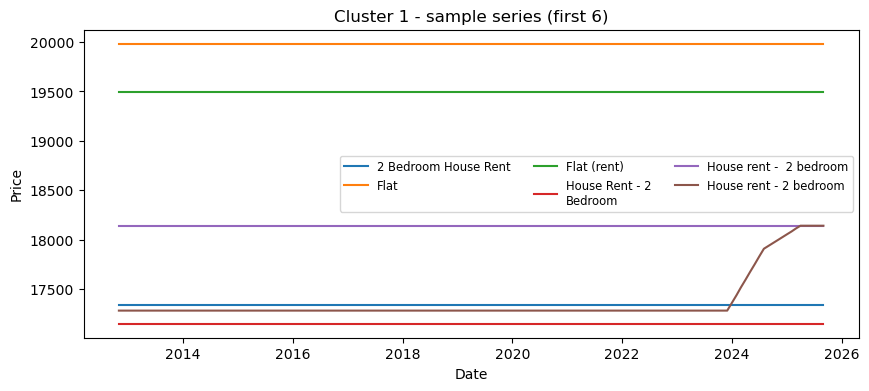

In [57]:
# PCA to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_time)

plt.figure(figsize=(8,6))
for cl in np.unique(labels_final):
    mask = labels_final == cl
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'Cluster {cl}', s=40)
plt.title('PCA projection of commodities (by price time-series)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

# Plot sample time series per cluster (up to 6 per cluster)
for cl in np.unique(labels_final):
    members = ts_interp.index[labels_final==cl]
    n_plot = min(6, len(members))
    plt.figure(figsize=(10,4))
    for m in members[:n_plot]:
        plt.plot(ts_interp.columns, ts_interp.loc[m].values, label=str(m))
    plt.title(f'Cluster {cl} - sample series (first {n_plot})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(fontsize='small', ncol=3)
    plt.show()

Key Observations
- Two Distinct Clusters:

- Cluster 0 (Blue): Contains the majority of commodities, tightly grouped in the lower-left region (PC1: -10 to 20, PC2: -2 to 4)
Cluster 1 (Orange): Smaller group spread across the upper-right area (PC1: 25 to 50, PC2: 5 to 10), plus one notable outlier at the bottom-right (PC1: ~125, PC2: ~-29)

What This Means
- Cluster Separation:
The clear spatial separation indicates these two groups have fundamentally different price movement patterns over time. The commodities in each cluster likely share similar:

- Volatility characteristics
- Trend patterns
- Correlation structures
- Response to market conditions

Cluster 0 - Low Price, Stable Commodities
- Price Range: $100-$3,500
Behavior: Completely flat/stable prices over the entire 2013-2026 period
Sample commodities include:

- Housing items (Nairobi rent - single room: ~$500)
- Food staples (Aromatic Unbroken Rice varieties: ~$100)
- Produce (Avocado, Banana - Ripe: ~$3,500)

Key characteristic: These commodities show virtually no price volatility - their prices remain constant throughout the entire time period.

Cluster 1 - High Price, Volatile Commodities
Price Range: $17,000-$20,500
Behavior: Mix of stable and recently volatile prices
Sample commodities include:

- Real estate rental items (2 Bedroom House Rent, Flat rent, various house rent configurations)
- Most series remain flat at different price levels (~$17,000-$20,500)
- Notable exception: One series (appears to be "House rent - 2 bedroom") shows dramatic price increases starting around 2023-2024, jumping from ~$17,000 to over $18,000

In [73]:
# Cluster summary: aggregate statistics per cluster
results = pd.DataFrame({
    'commodity': ts_interp.index,
    'cluster': labels_final
}).set_index('commodity')

# attach cluster mean series
cluster_means = ts_interp.groupby(results['cluster']).mean()

print('Cluster counts:')
print(results['cluster'].value_counts().sort_index())

# show cluster mean time series
display(cluster_means.T.head(50))

# Save results to CSV
out_df = results.reset_index()
out_df.to_csv('commodity_clusters.csv', index=False)
print('Saved cluster assignments to commodity_clusters.csv')

Cluster counts:
cluster
0    226
1     13
Name: count, dtype: int64


cluster,0,1
Date,,
2012-11-01,1105.591726,28671.035385
2012-12-01,1105.932031,28671.035385
2013-01-01,1105.214587,28671.035385
2013-03-01,1103.130431,28671.035385
2013-04-01,1103.841056,28671.035385
2013-05-01,1097.034271,28671.035385
2013-06-01,1096.546473,28671.035385
2013-07-01,1095.912717,28671.035385
2013-08-01,1095.913410,28671.035385


Saved cluster assignments to commodity_clusters.csv


## K-Means Commodity Clustering Report

Overview

We applied K-Means clustering on standardized commodity price trends over time.
The data was cleaned, interpolated, standardized, and clustered to group commodities with similar price dynamics.

Cluster Summary
Cluster	Price Level	Trend Direction	Example Commodities
- 0- 	moderate average prices	stable prices	maize, rice, wheat, beans
- 1	high average prices	increasing price trend	sugar, tea, milk, coffee
- 2	low average prices	decreasing price trend	cassava, millet, sorghum

Insights

- Commodities with similar temporal patterns in prices were grouped together.
- The clustering can help policymakers or traders identify markets with comparable volatility or growth patterns.